use the nolearn environment (source activate nolearn) to run this notebook  
Nolearn documentation: https://github.com/dnouri/nolearn/
Example setting up a network with nolearn: https://github.com/dnouri/nolearn/blob/master/docs/notebooks/CNN_tutorial.ipynb

## Notes on choosing architechture, hyperparameters, etc.

##### Number of Hidden Layers:
Problems that require two hidden layers are rarely encountered, however, NNs with two hidden layers can represent functions with any kind of shape.  There is currently no theoretical reason to use neural networks with any more than two hidden layers.  (from https://web.archive.org/web/20140721050413/http://www.heatonresearch.com/node/707)

##### Number of neurons in hidden layers:
There are many rule-of-thumb methods for determining the correct number of neurons to use in the hidden layers, such as the following:

-  The number of hidden neurons should be between the size of the input layer and the size of the output layer. 
-  The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer. 
-  The number of hidden neurons should be less than twice the size of the input layer. 
-  Additional rule of thumb for determining an upperbound on the number of hidden neurons that won't result in overfitting is: 

$$ N_h = \frac{N_s}{alpha*(N_i + N_o)} $$

&nbsp;&nbsp;&nbsp;&nbsp; $N_i$ = number of input neurons  
&nbsp;&nbsp;&nbsp;&nbsp; $N_o$ = number of output neurons  
&nbsp;&nbsp;&nbsp;&nbsp; $N_s$ = number of samples in training data set
&nbsp;&nbsp;&nbsp;&nbsp; alpha = arbitrary scaling factor (usually between 2-10)

##### Choosing the Learning Rate
-  First, estimate a threshold value at which the cost on the traning data immediately begins decreasing (do this by changing learning rate by orders of magnitude until you get a value where the cost increases during the first few epochs)
-  This threshold value changes with network architechture and whether the training data is normalized.  Small changes below the threshold value appear to have significant impacts on the results...
-  I need to do more digging into nolearn to determine if I can specify a learning rate schedule, or otherwise adjust the learning rate during training  
--> turns out you can do this fairly easily: see Daniel Nouri's tutorial linked above.

##### Regularization Parameter
First figure out learning rate without regularization, then add it.  Start with lambda = 1.0, then increase or decrease by factors of 10 to improve performance on the validation data.  After finding best lambda, return and re-optimize the learning rate again.
https://groups.google.com/forum/#!topic/lasagne-users/B3w6_EU9qlI  
https://www.kaggle.com/c/otto-group-product-classification-challenge/forums/t/14139/does-anyone-know-how-to-make-l1-and-l2-regularization-work-for-lasagne  

Should I just add dropout instead?  I read that dropout in a regression network is not a good idea, especially right before the output layer (https://cs231n.github.io/neural-networks-2/)  Both dropout and regularization only make sense if we have a network that is overfitting, so right now it doesn't look like I need it until I can make my network overfit...

To add L1 or L2 regularization, just add objective_l2=0.0001 to the NeuralNet.  
See: https://github.com/dnouri/nolearn/issues/199

In [1]:
import numpy as np
import pandas as pd
import matplotlib
# this was required on one of my machines while running in a conda environment
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

import lasagne
from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet

from sklearn import preprocessing
from sklearn.grid_search import GridSearchCV

%matplotlib inline

# specify the seed for random number generation so we can get consistent 
# shuffling and initialized weights
np.random.seed(6509)

#### Eventually, make this into a function that reads the data, cleans it appropriately, shuffles and normalizes it, and splits it into training/test sets

In [2]:
# Read the training data for the neural network
# Input data is 250000x4 and output data is 250000x32
X = pd.read_csv('../parameters_250000.txt', sep=' ')
Y = pd.read_csv('../results.txt', sep=' ', index_col=False)
# These functional groups do not exist in my model
Y = Y.drop(['light_aromatic_C-C', 'light_aromatic_methoxyl'], axis=1)

X = X.values.astype(np.float32)
Y = Y.values.astype(np.float32)
print X.shape, Y.shape

(250000, 4) (250000, 30)


In [3]:
# Shuffle the dataset (because x parameters are varied in a structured way)
combined = np.concatenate((X, Y), axis=1)
np.random.shuffle(combined)

# Separate the data into training (with included validation) and test sets.
# (Validation set is separated from the training set by nolearn)
test_fraction = 0.2
training = combined[:-int(test_fraction * combined.shape[0]), :]
test = combined[-int(test_fraction * combined.shape[0]):, :]
print training.shape, test.shape

x_train = training[:, :4]
y_train = training[:, 4:]
x_test = test[:, :4]
y_test = test[:, 4:]

# Standardize the input parameters to have zero mean and unit variance
# x_scaler.transform() can be used later to transform any new data
# x_scaler.inverse_transform() can be used to get the original data back
x_scaler = preprocessing.StandardScaler().fit(x_train)
x_train = x_scaler.transform(x_train)
x_test = x_scaler.transform(x_test)

# Scale the output parameters to lie between 0 and 1
y_scaler = preprocessing.MinMaxScaler().fit(y_train)
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)


(200000, 34) (50000, 34)


In [4]:
# NeuralNet automatically splits the data provided into a training
# and a validation set, using 20% of the samples for validation. 
# You can adjust this ratio by overriding the eval_size=0.2 parameter.
# default objective is lasagne.objectives.squared_error.
net = NeuralNet(
            layers=[
                ('input', layers.InputLayer),
                ('hidden0', layers.DenseLayer),
#                 ('hidden1', layers.DenseLayer),
                ('output', layers.DenseLayer)
                ],
            input_shape=(None, x_train.shape[1]),
            hidden0_num_units=22,
            hidden0_nonlinearity=nonlinearities.sigmoid,
#             hidden1_num_units=17,
#             hidden1_nonlinearity=nonlinearities.sigmoid,
            output_num_units=y_train.shape[1],
            output_nonlinearity=nonlinearities.linear,
            regression=True,
#             update=lasagne.updates.nesterov_momentum,
#             update_momentum=0.9,
            update_learning_rate=0.9,
            verbose=1,
            max_epochs=1100,
#             train_split=TrainSplit(eval_size=0.2),          
#             objective_l2=0.0001
            # use on_epoch_finished to update the learning rate during training
            # or use early stopping.
            # see https://github.com/dnouri/kfkd-tutorial/blob/master/kfkd.py
            )


In [5]:
net.fit(x_train[:8000,:], y_train[:8000,:])
print(net.score(x_train, y_train))

# The table that is printed shows the current loss (MSE) on the training and
# validation sets.

# Neural Network with 800 learnable parameters

## Layer information

  #  name       size
---  -------  ------
  0  input         4
  1  hidden0      22
  2  output       30

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.02373       0.00585      4.05643  0.03s
      2       0.00586       0.00560      1.04683  0.03s
      3       0.00578       0.00556      1.03998  0.03s
      4       0.00574       0.00551      1.04070  0.03s
      5       0.00569       0.00546      1.04181  0.03s
      6       0.00562       0.00539      1.04340  0.03s
      7       0.00554       0.00530      1.04558  0.03s
      8       0.00544       0.00518      1.04842  0.03s
      9       0.00530       0.00504      1.05183  0.03s
     10       0.00513       0.00486      1.05544  0.03s
     11       0.00493       0.00466      1.05852  0.03s
     12       0.00471       0.00444      1.06019  0.03s
     13       0.00448       0.00423      1

#### Gridsearch

In [10]:
# Use get_params to get all the hyperparameters that make up the estimator.
# Any of these parameters can be optimized with gridsearch
# net.get_params()
param_grid = {'hidden0_num_units': range(4, 40),
              'update_learning_rate': [0.1, 0.3, 0.5, 0.7],
              'max_epochs': [65]
              }

grid_search = GridSearchCV(net, param_grid, verbose=0, n_jobs=3)
grid_search.fit(x_train[:1000,:], y_train[:1000,:])

# Neural Network with 170 learnable parameters

## Layer information

  #  name       size
---  -------  ------
  0  input         4
  1  hidden0       4
  2  output       30

# Neural Network with 170 learnable parameters

## Layer information

  #  name       size
---  -------  ------
  0  input         4
  1  hidden0       4
  2  output       30

# Neural Network with 170 learnable parameters

## Layer information

  #  name       size
---  -------  ------
  0  input         4
  1  hidden0       4
  2  output       30

      1       0.30015       0.18928      1.58580  0.00s
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.30015       0.18928      1.58580  0.00s
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.30015       0.18928      1.58580  0.00s
      2       0.15448       0.07997      1.93183  0.00s
      2       0.15448       

GridSearchCV(cv=None, error_score='raise',
       estimator=NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x1181ca510>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x1181ca3d0>,
     custom_scores=None,
     hidden0_nonlinearity=<function sigmoid at 0x117ccc758>,
   ...arning_rate=0.5, use_label_encoder=False, verbose=1,
     y_tensor_type=TensorType(float64, matrix)),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'hidden0_num_units': [4, 17]}, pre_dispatch='2*n_jobs',
       refit=True, scoring=None, verbose=0)

In [11]:
# this shows you the scores for all the different searches
grid_search.grid_scores_

[mean: 0.00624, std: 0.00034, params: {'hidden0_num_units': 4},
 mean: 0.00547, std: 0.00056, params: {'hidden0_num_units': 17}]

In [35]:
# quickly show which was the estimator with the best score
grid_search.best_params_

{'hidden0_num_units': 4}

In [65]:
# This is the NeuralNet object with the best fit
grid_search.best_estimator_

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x11af7b990>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x119793d50>,
     custom_scores=None,
     hidden0_nonlinearity=<function sigmoid at 0x117ccc758>,
     hidden0_num_units=4, input_shape=(None, 4),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden0', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=100, more_params={},
     objective=<function objective at 0x1181cbd70>,
     objective_loss_function=<function squared_error at 0x117f56848>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x11a8e8200>, <nolearn.lasagne.handlers.PrintLog instance at 0x11a8e8e18>, <nolearn.lasagne.handlers.PrintLog instance at 0x11a5547e8>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handler

In [67]:
# Get the parameter values for the grid search estimator with the best score.  
grid_search.best_estimator_.get_all_params_values()

OrderedDict([('input', []),
             ('hidden0',
              [array([[ 0.82717303,  0.36639034, -0.46519339,  0.57391125],
                      [ 0.08015673, -0.01211673, -0.04707254, -0.02730539],
                      [ 0.79267612, -0.00225379,  0.3714557 , -1.06461549],
                      [ 0.0798195 , -1.47573683, -0.49696656,  0.24590409]]),
               array([ 0.01844891, -0.25743825, -0.43708181, -0.36295953])]),
             ('output',
              [array([[-0.16154601,  0.34482383, -0.1213812 ,  0.05371199,  0.59179406,
                       -0.47744987,  0.25396267,  0.23619294, -0.59074859, -0.0981154 ,
                       -0.2807859 ,  0.33057431, -0.42968999, -0.33308786,  0.40107758,
                        0.10656008, -0.59665256,  0.12694752, -0.21018033, -0.49049565,
                       -0.31841023,  0.6658754 , -0.06632966, -0.6504345 , -0.04888123,
                        0.29515824,  0.17047779,  0.13659074, -0.04343507, -0.14303251],
          

In [62]:
# Predict using the weights from the estimator with the best score
# confirmed: this gives the same result
grid_search.predict(x_test)

array([[ 0.26679855,  0.78608762,  0.37384447, ...,  0.01653872,
         0.29723042,  0.8766193 ],
       [ 0.34192492,  0.33881532,  0.46703772, ...,  0.56203219,
         0.26255374,  0.28796508],
       [ 0.3180709 ,  0.08597064,  0.44793183, ...,  0.48432258,
         0.36680448,  0.37560062],
       ..., 
       [ 0.23799071,  0.40150157,  0.37818704, ...,  0.25411331,
         0.34245741,  0.62787445],
       [ 0.47224512,  0.2838987 ,  0.54609495, ...,  0.62895225,
         0.27774852,  0.20161288],
       [ 0.20320797,  0.17552789,  0.37760186, ...,  0.49622025,
         0.33849963,  0.3734602 ]])

In [9]:
# from sklearn.learning_curve import validation_curve
# train_scores, valid_scores = validation_curve(net, x_train, y_train,
#                                               'update_learning_rate', [0.5, 1],
#                                               verbose=1)

In [35]:
# This returns a dictionary with {layer_name: list_of_numpy_arrays} containing
# all the network's parameters.
net.get_all_params_values()
# the first array for a layer in this dictionary contains rows of weights;
# each row's length is the number of units in the layer referenced, and the
# number of rows corresponds to the number of units feeding into this layer.
# the second array is the biases for each unit in the layer.

# access specific layer paramters this way:
# net.layers_['hidden0'].get_params()
# net.layers_['hidden0'].W.get_value()

OrderedDict([('input', []),
             ('hidden0',
              [array([[-0.3953085 ,  0.16252052,  1.83828617,  0.9805676 ,  0.55426251,
                       -1.57914667,  0.79946677,  2.11889281,  1.21248673,  0.97049893,
                        0.0139903 ,  0.95324236, -0.74193536,  0.52135382, -0.10005534],
                      [ 0.02289055,  0.96096652, -0.45761008, -0.38628325,  0.10253526,
                        0.50094694,  0.62494895, -0.22446546, -0.18152636,  0.13824899,
                        0.00354266,  0.13019602,  0.10905882,  0.68723668, -0.07388514],
                      [ 2.047093  , -0.12977113, -0.20448486,  0.94744705,  0.16667141,
                       -0.09015978, -0.038645  , -0.70218135, -0.88099453,  1.05806262,
                       -0.16665966, -0.95772669, -0.50545291,  1.29953857,  0.2828916 ],
                      [ 1.10978945,  0.27535175, -0.89395838, -0.34248136, -0.77568468,
                       -0.25674834,  0.01269024,  0.00786552,  0

In [ ]:
# how to save and load
net.save_params_to('some file')
# then later
net = pickle.load(f)
net.load_params_from('some file')
# at this point you can continue training or doing stuff with the model...
net.predict()


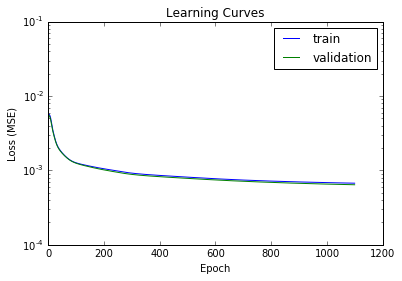

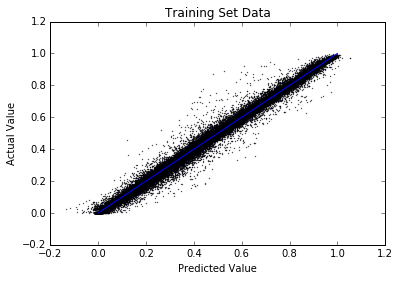

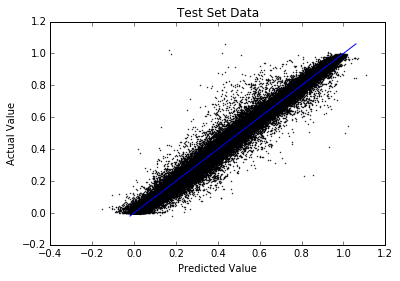

In [6]:
# Plot the learning curves
# helpful in determining whether to continue training or not.
# if both loss functions still are still decreasing: more training will pay off.
# If the train loss is much lower than the validation loss, should regularize. 
train_loss = np.array([i["train_loss"] for i in net.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net.train_history_])

plt.figure(1)
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.yscale('log')
plt.title('Learning Curves')

# Parity plot of the training data
plt.figure(2)
y_predictions = net.predict(x_train)
plt.scatter(y_predictions[:2000,:].flatten(), y_train[:2000,:].flatten(),
            s=0.1)
plt.plot([np.min(y_train),np.max(y_train)],[np.min(y_train),np.max(y_train)])
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.title('Training Set Data')

# Parity plot of the test data
plt.figure(3)
y_predictions_test = net.predict(x_test)
plt.scatter(y_predictions_test[:2000,:].flatten(), y_test[:2000,:].flatten(),
           s=0.2)
plt.plot([np.min(y_test),np.max(y_test)],[np.min(y_test),np.max(y_test)])
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.title('Test Set Data')


#### Next steps:

- How are weights initialized?
- Why are my training and validation errors so close - validation should start increasing eventually.  Can I make it do this if I train on a smaller dataset?
- Optimize
- benchmark the trained model compared with solving the ODEs
- incorporate the ANN into a whole particle model?
- extend the network to predict temporal data by adding time as an input